In [10]:
import pandas
from pandas import read_excel, date_range, DatetimeIndex, DataFrame, to_numeric, concat, to_datetime
from pandas.plotting import lag_plot, autocorrelation_plot
from pandas.tseries.offsets import DateOffset, MonthEnd, MonthBegin

import numpy
from numpy import logical_not

import statistics
import dateutil.relativedelta
from dateutil.relativedelta import relativedelta

import fbprophet
from fbprophet import Prophet

import calendar
from calendar import monthrange

from datetime import datetime, timedelta
from matplotlib import pyplot

from sklearn.metrics import mean_absolute_error, mean_squared_error

from math import sqrt

In [11]:
# esto no va en produccion

# cambiamos el valor de estos 4 parametros para que nos muestre dataframes sin truncarlos
pandas.set_option('display.max_rows', 12)
# pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.width', None)
pandas.set_option('display.max_colwidth', None)

In [12]:
# vamos a crear una serie temporal agrupando el gasto por meses

In [13]:
# Load data using read_excel
transacciones_df = read_excel('20210513 mmelero (249236).xlsx', sheet_name='Hoja1')
transacciones_df

Fecha transacción  Importe  ID Categoría           Nombre categoría  \
0           2020-07-24    -1.20          84.0                 parking_84   
1           2020-07-23    -4.50         117.0  regalos_celebraciones_117   
2           2020-07-23   -13.53          70.0           supermercados_70   
3           2020-07-22   -51.40         222.0                   adsl_222   
4           2020-07-22   -11.00          70.0           supermercados_70   
...                ...      ...           ...                        ...   
1482        2016-09-05  1533.02          18.0     retribucion_liquida_18   
1483        2016-09-05  -617.47         126.0    liquidacion_tarjeta_126   
1484        2016-09-05  -138.08         125.0                 cuotas_125   
1485        2016-09-01   -32.22          90.0            seguro_salud_90   
1486        2016-09-01   -33.00         434.0                 cuotas_434   

      Nivel categoría  iD categoría padre Nombre categoría padre  \
0                 2.0                 5.0            vehiculos_5   
1                 2.0                 8.0    gastos_personales_8   
2                 2.0                 4.0         alimentacion_4   
3                 3.0               521.0    Comunicaciones y TV   
4                 2.0                 4.0         alimentacion_4   
...               ...                 ...                    ...   
1482              3.0               576.0                 Nómina   
1483              3.0               478.0   tarjetas_credito_478   
1484              3.0               127.0      otros_pasivos_127   
1485              2.0                 6.0                salud_6   
1486              3.0               115.0           deportes_115   

                    Proveedor               Marca  \
0                         NaN                 NaN   
1                         NaN                 NaN   
2                        SPAR                SPAR   
3                Jazz Telecom             Jazztel   
4                   Mercadona           Mercadona   
...                       ...                 ...   
1482                      NaN                 NaN   
1483                      NaN                 NaN   
1484                      NaN                 NaN   
1485  Sanitas S.A. de Seguros             Sanitas   
1486       Royal Sport Center  Royal Sport Center   

                            Sector  Financiero  Transferencia  Unnamed: 12  \
0                              NaN       False          False          NaN   
1                              NaN       False          False          NaN   
2                    Supermercados       False          False          NaN   
3     Compañías telecomunicaciones       False          False          NaN   
4                    Supermercados       False          False          NaN   
...                            ...         ...            ...          ...   
1482                           NaN       False          False          NaN   
1483                           NaN        True           True          NaN   
1484                           NaN        True          False          NaN   
1485              Seguros de salud        True          False          NaN   
1486              Clubs deportivos       False          False          NaN   

      Unnamed: 13        ID  BALANCE BALANCE_DATE  
0             NaN  249236.0  1478.98   2020-07-26  
1             NaN       NaN      NaN          NaT  
2             NaN       NaN      NaN          NaT  
3             NaN       NaN      NaN          NaT  
4             NaN       NaN      NaN          NaT  
...           ...       ...      ...          ...  
1482          NaN       NaN      NaN          NaT  
1483          NaN       NaN      NaN          NaT  
1484          NaN       NaN      NaN          NaT  
1485          NaN       NaN      NaN          NaT  
1486          NaN       NaN      NaN          NaT  

[1487 rows x 17 columns]

In [14]:
# nos quedamos con la fecha en que nos dan los datos de las transacciones
last_date_obj = transacciones_df.loc[0, 'BALANCE_DATE']
last_date_obj

Timestamp('2020-07-26 00:00:00')

In [15]:
# nos quedamos con las transacciones de la categoría 'supermercados_70'
transacciones_super_df = transacciones_df[transacciones_df['ID Categoría'] == 70.0]
transacciones_super_df

Fecha transacción  Importe  ID Categoría  Nombre categoría  \
2           2020-07-23   -13.53          70.0  supermercados_70   
4           2020-07-22   -11.00          70.0  supermercados_70   
6           2020-07-22   -73.77          70.0  supermercados_70   
9           2020-07-20   -16.17          70.0  supermercados_70   
12          2020-07-20   -14.75          70.0  supermercados_70   
...                ...      ...           ...               ...   
1427        2016-11-03   -18.21          70.0  supermercados_70   
1436        2016-10-25  -147.50          70.0  supermercados_70   
1444        2016-10-24   -21.48          70.0  supermercados_70   
1456        2016-10-11    -8.74          70.0  supermercados_70   
1465        2016-10-06    -8.58          70.0  supermercados_70   

      Nivel categoría  iD categoría padre Nombre categoría padre  Proveedor  \
2                 2.0                 4.0         alimentacion_4       SPAR   
4                 2.0                 4.0         alimentacion_4  Mercadona   
6                 2.0                 4.0         alimentacion_4       Aldi   
9                 2.0                 4.0         alimentacion_4       SPAR   
12                2.0                 4.0         alimentacion_4       Lidl   
...               ...                 ...                    ...        ...   
1427              2.0                 4.0         alimentacion_4       SPAR   
1436              2.0                 4.0         alimentacion_4  Carrefour   
1444              2.0                 4.0         alimentacion_4       SPAR   
1456              2.0                 4.0         alimentacion_4       SPAR   
1465              2.0                 4.0         alimentacion_4       SPAR   

          Marca         Sector  Financiero  Transferencia  Unnamed: 12  \
2          SPAR  Supermercados       False          False          NaN   
4     Mercadona  Supermercados       False          False          NaN   
6          Aldi  Supermercados       False          False          NaN   
9          SPAR  Supermercados       False          False          NaN   
12         Lidl  Supermercados       False          False          NaN   
...         ...            ...         ...            ...          ...   
1427       SPAR  Supermercados       False          False          NaN   
1436  Carrefour  Supermercados       False          False          NaN   
1444       SPAR  Supermercados       False          False          NaN   
1456       SPAR  Supermercados       False          False          NaN   
1465       SPAR  Supermercados       False          False          NaN   

      Unnamed: 13  ID  BALANCE BALANCE_DATE  
2             NaN NaN      NaN          NaT  
4             NaN NaN      NaN          NaT  
6             NaN NaN      NaN          NaT  
9             NaN NaN      NaN          NaT  
12            NaN NaN      NaN          NaT  
...           ...  ..      ...          ...  
1427          NaN NaN      NaN          NaT  
1436          NaN NaN      NaN          NaT  
1444          NaN NaN      NaN          NaT  
1456          NaN NaN      NaN          NaT  
1465          NaN NaN      NaN          NaT  

[284 rows x 17 columns]

In [16]:
# nos quedamos con columnas desde 'Fecha transacción' hasta 'Importe'
transacciones_super_df = transacciones_super_df.iloc[:, 0:2]
transacciones_super_df

Fecha transacción  Importe
2           2020-07-23   -13.53
4           2020-07-22   -11.00
6           2020-07-22   -73.77
9           2020-07-20   -16.17
12          2020-07-20   -14.75
...                ...      ...
1427        2016-11-03   -18.21
1436        2016-10-25  -147.50
1444        2016-10-24   -21.48
1456        2016-10-11    -8.74
1465        2016-10-06    -8.58

[284 rows x 2 columns]

In [17]:
# ya no necesitamos transacciones_df
del transacciones_df

In [18]:
# renombramos columnas
transacciones_super_df.rename(columns={'Fecha transacción': 'FECHA', 'Importe': 'IMPORTE'}, inplace=True)
transacciones_super_df

FECHA  IMPORTE
2    2020-07-23   -13.53
4    2020-07-22   -11.00
6    2020-07-22   -73.77
9    2020-07-20   -16.17
12   2020-07-20   -14.75
...         ...      ...
1427 2016-11-03   -18.21
1436 2016-10-25  -147.50
1444 2016-10-24   -21.48
1456 2016-10-11    -8.74
1465 2016-10-06    -8.58

[284 rows x 2 columns]

In [19]:
# ordenamos las fechas por orden ascendente
transacciones_super_df.sort_values(by=['FECHA'], ascending=True, inplace=True, ignore_index=True)
transacciones_super_df

FECHA  IMPORTE
0   2016-10-06    -8.58
1   2016-10-11    -8.74
2   2016-10-24   -21.48
3   2016-10-25  -147.50
4   2016-11-03   -18.21
..         ...      ...
279 2020-07-20   -14.75
280 2020-07-20   -16.17
281 2020-07-22   -73.77
282 2020-07-22   -11.00
283 2020-07-23   -13.53

[284 rows x 2 columns]

In [20]:
# vamos a agrupar los valores y sumarlos por fecha
transacciones_super_df = transacciones_super_df.groupby(['FECHA']).sum()
transacciones_super_df

IMPORTE
FECHA              
2016-10-06    -8.58
2016-10-11    -8.74
2016-10-24   -21.48
2016-10-25  -147.50
2016-11-03   -18.21
...             ...
2020-07-15    -6.61
2020-07-17   -12.72
2020-07-20   -30.92
2020-07-22   -84.77
2020-07-23   -13.53

[214 rows x 1 columns]

In [21]:
# esto no va en produccion

# comprobamos que el indice sea datetime o DatetimeIndex
type(transacciones_super_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [22]:
# hacemos una columna con el indice
transacciones_super_df['FECHA'] = transacciones_super_df.index
transacciones_super_df

IMPORTE      FECHA
FECHA                         
2016-10-06    -8.58 2016-10-06
2016-10-11    -8.74 2016-10-11
2016-10-24   -21.48 2016-10-24
2016-10-25  -147.50 2016-10-25
2016-11-03   -18.21 2016-11-03
...             ...        ...
2020-07-15    -6.61 2020-07-15
2020-07-17   -12.72 2020-07-17
2020-07-20   -30.92 2020-07-20
2020-07-22   -84.77 2020-07-22
2020-07-23   -13.53 2020-07-23

[214 rows x 2 columns]

In [23]:
# esto no va en produccion

# comprobamos que 'FECHA' sea datetime
transacciones_super_df.dtypes

IMPORTE           float64
FECHA      datetime64[ns]
dtype: object

In [24]:
# sumamos la cuantía de las transacciones de cada mes y la suma la ponemos fecha del inicio de cada mes
transacciones_month_df = transacciones_super_df.groupby(pandas.Grouper(key='FECHA', freq="MS")).sum()
transacciones_month_df

IMPORTE
FECHA              
2016-10-01  -186.30
2016-11-01  -181.69
2016-12-01  -265.52
2017-01-01  -458.75
2017-02-01  -181.12
...             ...
2020-03-01     0.00
2020-04-01     0.00
2020-05-01  -344.47
2020-06-01  -293.41
2020-07-01  -247.50

[46 rows x 1 columns]

In [26]:
# ya no necesitamos transacciones_super_df
del transacciones_super_df

In [25]:
# para que los datos sean más fáciles de interpretar vamos a hacerlos todos positivos multiplicándolos por '-1'
transacciones_month_df['IMPORTE'] = -transacciones_month_df['IMPORTE']
transacciones_month_df

IMPORTE
FECHA              
2016-10-01   186.30
2016-11-01   181.69
2016-12-01   265.52
2017-01-01   458.75
2017-02-01   181.12
...             ...
2020-03-01    -0.00
2020-04-01    -0.00
2020-05-01   344.47
2020-06-01   293.41
2020-07-01   247.50

[46 rows x 1 columns]

In [28]:
# en transacciones_mfilled_df rellenaremos las fechas sin importe con el importe valido inmediatamente anterior
transacciones_mfilled_df = transacciones_month_df.copy()
transacciones_mfilled_df

IMPORTE
FECHA              
2016-10-01   186.30
2016-11-01   181.69
2016-12-01   265.52
2017-01-01   458.75
2017-02-01   181.12
...             ...
2020-03-01    -0.00
2020-04-01    -0.00
2020-05-01   344.47
2020-06-01   293.41
2020-07-01   247.50

[46 rows x 1 columns]

In [29]:
# ya no necesitamos transacciones_month_df
del transacciones_month_df

In [30]:
# hacemos una columna con la fecha del indice
transacciones_mfilled_df['FECHA'] = transacciones_mfilled_df.index
transacciones_mfilled_df

IMPORTE      FECHA
FECHA                         
2016-10-01   186.30 2016-10-01
2016-11-01   181.69 2016-11-01
2016-12-01   265.52 2016-12-01
2017-01-01   458.75 2017-01-01
2017-02-01   181.12 2017-02-01
...             ...        ...
2020-03-01    -0.00 2020-03-01
2020-04-01    -0.00 2020-04-01
2020-05-01   344.47 2020-05-01
2020-06-01   293.41 2020-06-01
2020-07-01   247.50 2020-07-01

[46 rows x 2 columns]

In [31]:
# indice de fechas hasta el ultimo dia del mes para el cual hay datos
idx = date_range(start=transacciones_mfilled_df.FECHA.min(), end=transacciones_mfilled_df.FECHA.max() + MonthEnd(1))
idx

DatetimeIndex(['2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04',
               '2016-10-05', '2016-10-06', '2016-10-07', '2016-10-08',
               '2016-10-09', '2016-10-10',
               ...
               '2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25',
               '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29',
               '2020-07-30', '2020-07-31'],
              dtype='datetime64[ns]', length=1400, freq='D')

In [32]:
# esto no va en produccion

# comprobamos que el indice de transacciones_mfilled_df es de tipo DatetimeIndex 
type(transacciones_mfilled_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [33]:
# rellenamos las missing dates en el indice
transacciones_mfilled_df = transacciones_mfilled_df.reindex(idx, fill_value='NaN')
transacciones_mfilled_df

IMPORTE      FECHA
2016-10-01   186.3 2016-10-01
2016-10-02     NaN        NaT
2016-10-03     NaN        NaT
2016-10-04     NaN        NaT
2016-10-05     NaN        NaT
...            ...        ...
2020-07-27     NaN        NaT
2020-07-28     NaN        NaT
2020-07-29     NaN        NaT
2020-07-30     NaN        NaT
2020-07-31     NaN        NaT

[1400 rows x 2 columns]

In [34]:
# hacemos drop de la columna FECHA
transacciones_mfilled_df.drop(columns='FECHA', inplace=True)
transacciones_mfilled_df

IMPORTE
2016-10-01   186.3
2016-10-02     NaN
2016-10-03     NaN
2016-10-04     NaN
2016-10-05     NaN
...            ...
2020-07-27     NaN
2020-07-28     NaN
2020-07-29     NaN
2020-07-30     NaN
2020-07-31     NaN

[1400 rows x 1 columns]

In [35]:
# esto no va en produccion

# comprobamos si el tipo de IMPORTE es numerico
transacciones_mfilled_df.dtypes

IMPORTE    object
dtype: object

In [36]:
# pasamos IMPORTE a formato 'numeric'
transacciones_mfilled_ser = transacciones_mfilled_df.T.squeeze()
transacciones_mfilled_ser

2016-10-01    186.3
2016-10-02      NaN
2016-10-03      NaN
2016-10-04      NaN
2016-10-05      NaN
              ...  
2020-07-27      NaN
2020-07-28      NaN
2020-07-29      NaN
2020-07-30      NaN
2020-07-31      NaN
Freq: D, Name: IMPORTE, Length: 1400, dtype: object

In [37]:
transacciones_mfilled_ser = to_numeric(transacciones_mfilled_ser, errors='coerce')
transacciones_mfilled_ser

2016-10-01    186.3
2016-10-02      NaN
2016-10-03      NaN
2016-10-04      NaN
2016-10-05      NaN
              ...  
2020-07-27      NaN
2020-07-28      NaN
2020-07-29      NaN
2020-07-30      NaN
2020-07-31      NaN
Freq: D, Name: IMPORTE, Length: 1400, dtype: float64

In [38]:
transacciones_mfilled_df = DataFrame(transacciones_mfilled_ser)
del transacciones_mfilled_ser
transacciones_mfilled_df

IMPORTE
2016-10-01    186.3
2016-10-02      NaN
2016-10-03      NaN
2016-10-04      NaN
2016-10-05      NaN
...             ...
2020-07-27      NaN
2020-07-28      NaN
2020-07-29      NaN
2020-07-30      NaN
2020-07-31      NaN

[1400 rows x 1 columns]

In [39]:
# esto no va en produccion

# comprobamos si el tipo de IMPORTE es numerico
transacciones_mfilled_df.dtypes

IMPORTE    float64
dtype: object

In [40]:
# rellenamos los NaN con el ultimo valor numérico anterior
transacciones_mfilled_df['IMPORTE'].fillna(method='ffill', inplace=True)
transacciones_mfilled_df

IMPORTE
2016-10-01    186.3
2016-10-02    186.3
2016-10-03    186.3
2016-10-04    186.3
2016-10-05    186.3
...             ...
2020-07-27    247.5
2020-07-28    247.5
2020-07-29    247.5
2020-07-30    247.5
2020-07-31    247.5

[1400 rows x 1 columns]

In [41]:
# a continuación vamos a estimar con prophet la serie temporal del importe con los datos del dataframe
# 'transacciones_mfilled_df'
# vamos a entrenar la serie desde el segundo mes de transacciones_mfilled_df hasta el penúltimo mes de
# transacciones_mfilled_df porque para el primer y ultimo mes de datos en ocasiones no se dispondrá del mes completo
# con lo que tenemos valores inferiores de IMPORTE para esos meses que distorsionan el calculo de la serie temporal

In [42]:
prophet_train_df = transacciones_mfilled_df.copy()
prophet_train_df

IMPORTE
2016-10-01    186.3
2016-10-02    186.3
2016-10-03    186.3
2016-10-04    186.3
2016-10-05    186.3
...             ...
2020-07-27    247.5
2020-07-28    247.5
2020-07-29    247.5
2020-07-30    247.5
2020-07-31    247.5

[1400 rows x 1 columns]

In [43]:
# Time Series Forecasting With Prophet in Python
# https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [44]:
# Fit Prophet Model

In [45]:
# para los datos de training tenemos que quitar los datos del mes en el que pedimos la estimación.
# ya que si hacemos la estimación al principio del mes el gasto en supermercados sera mucho menor respecto al gasto
# en supermercados de un mes completo similar

In [46]:
# hacemos una columna con el indice que se llame fecha
prophet_train_df['FECHA'] = prophet_train_df.index
prophet_train_df

IMPORTE      FECHA
2016-10-01    186.3 2016-10-01
2016-10-02    186.3 2016-10-02
2016-10-03    186.3 2016-10-03
2016-10-04    186.3 2016-10-04
2016-10-05    186.3 2016-10-05
...             ...        ...
2020-07-27    247.5 2020-07-27
2020-07-28    247.5 2020-07-28
2020-07-29    247.5 2020-07-29
2020-07-30    247.5 2020-07-30
2020-07-31    247.5 2020-07-31

[1400 rows x 2 columns]

In [47]:
# calculamos el ultimo año
last_year = prophet_train_df['FECHA'].dt.year.max()
last_year

2020

In [48]:
# calculamos el ultimo mes del ultimo año
last_month = prophet_train_df[str(last_year)]['FECHA'].dt.month.max()
last_month

<ipython-input-48-27e5322a8c95>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  last_month = prophet_train_df[str(last_year)]['FECHA'].dt.month.max()


7

In [49]:
# hacemos un string con el ultimo año y mes para hacer una mascara
last_year_month = str(last_year) + '-' + str(last_month)
last_year_month

'2020-7'

In [50]:
# calculamos la fecha maxima para quitarnos las transacciones en fecha iguales o posterior a esta
maximum_date_obj = prophet_train_df[last_year_month]['FECHA'].min()
maximum_date_obj

<ipython-input-50-f5b0fabd2646>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  maximum_date_obj = prophet_train_df[last_year_month]['FECHA'].min()


Timestamp('2020-07-01 00:00:00')

In [51]:
# hacemos una mascara para quitar las filas del ultimo mes
before_maximum_date_ser = prophet_train_df['FECHA'] < maximum_date_obj
before_maximum_date_ser

2016-10-01     True
2016-10-02     True
2016-10-03     True
2016-10-04     True
2016-10-05     True
              ...  
2020-07-27    False
2020-07-28    False
2020-07-29    False
2020-07-30    False
2020-07-31    False
Freq: D, Name: FECHA, Length: 1400, dtype: bool

In [52]:
# aplicamos la mascara
prophet_train_df = prophet_train_df.loc[before_maximum_date_ser]
prophet_train_df

IMPORTE      FECHA
2016-10-01   186.30 2016-10-01
2016-10-02   186.30 2016-10-02
2016-10-03   186.30 2016-10-03
2016-10-04   186.30 2016-10-04
2016-10-05   186.30 2016-10-05
...             ...        ...
2020-06-26   293.41 2020-06-26
2020-06-27   293.41 2020-06-27
2020-06-28   293.41 2020-06-28
2020-06-29   293.41 2020-06-29
2020-06-30   293.41 2020-06-30

[1369 rows x 2 columns]

In [53]:
# también tenemos que quitar del dataframe los datos del primer mes porque también puede estar no completo y nos
# desvirtúa también la serie temporal del entrenamiento

In [54]:
# calculamos el primer año del dataframe
first_year = prophet_train_df['FECHA'].dt.year.min()
first_year

2016

In [55]:
# calculamos el primer mes del primer año
first_month = prophet_train_df[str(first_year)]['FECHA'].dt.month.min()
first_month

<ipython-input-55-80bd3efc9827>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  first_month = prophet_train_df[str(first_year)]['FECHA'].dt.month.min()


10

In [56]:
# hacemos un string con el primer mes del primer año para hacer una mascara
first_year_month = str(first_year) + '-' + str(first_month)
first_year_month

'2016-10'

In [57]:
# calculamos la fecha minima para quedarnos con todas las transacciones del dataframe posteriores a esa fecha
minimum_date_obj = prophet_train_df[first_year_month]['FECHA'].max()
minimum_date_obj

<ipython-input-57-51c03972f9c0>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  minimum_date_obj = prophet_train_df[first_year_month]['FECHA'].max()


Timestamp('2016-10-31 00:00:00')

In [59]:
# hago una mascara para quitar las filas del primer mes
after_minimum_date_ser = prophet_train_df['FECHA'] > minimum_date_obj
after_minimum_date_ser

2016-10-01    False
2016-10-02    False
2016-10-03    False
2016-10-04    False
2016-10-05    False
              ...  
2020-06-26     True
2020-06-27     True
2020-06-28     True
2020-06-29     True
2020-06-30     True
Freq: D, Name: FECHA, Length: 1369, dtype: bool

In [60]:
# aplicamos la mascara anterior
prophet_train_df = prophet_train_df.loc[after_minimum_date_ser]
prophet_train_df

IMPORTE      FECHA
2016-11-01   181.69 2016-11-01
2016-11-02   181.69 2016-11-02
2016-11-03   181.69 2016-11-03
2016-11-04   181.69 2016-11-04
2016-11-05   181.69 2016-11-05
...             ...        ...
2020-06-26   293.41 2020-06-26
2020-06-27   293.41 2020-06-27
2020-06-28   293.41 2020-06-28
2020-06-29   293.41 2020-06-29
2020-06-30   293.41 2020-06-30

[1338 rows x 2 columns]

In [61]:
# reordenamos las columnas de prophet_train_df
prophet_train_df = prophet_train_df[['FECHA', 'IMPORTE']]
prophet_train_df

FECHA  IMPORTE
2016-11-01 2016-11-01   181.69
2016-11-02 2016-11-02   181.69
2016-11-03 2016-11-03   181.69
2016-11-04 2016-11-04   181.69
2016-11-05 2016-11-05   181.69
...               ...      ...
2020-06-26 2020-06-26   293.41
2020-06-27 2020-06-27   293.41
2020-06-28 2020-06-28   293.41
2020-06-29 2020-06-29   293.41
2020-06-30 2020-06-30   293.41

[1338 rows x 2 columns]

In [62]:
# prepare expected column names
prophet_train_df.columns = ['ds', 'y']
prophet_train_df

ds       y
2016-11-01 2016-11-01  181.69
2016-11-02 2016-11-02  181.69
2016-11-03 2016-11-03  181.69
2016-11-04 2016-11-04  181.69
2016-11-05 2016-11-05  181.69
...               ...     ...
2020-06-26 2020-06-26  293.41
2020-06-27 2020-06-27  293.41
2020-06-28 2020-06-28  293.41
2020-06-29 2020-06-29  293.41
2020-06-30 2020-06-30  293.41

[1338 rows x 2 columns]

In [63]:
# reseteamos la columna del dataframe
prophet_train_df.reset_index(drop=True, inplace=True)
prophet_train_df

ds       y
0    2016-11-01  181.69
1    2016-11-02  181.69
2    2016-11-03  181.69
3    2016-11-04  181.69
4    2016-11-05  181.69
...         ...     ...
1333 2020-06-26  293.41
1334 2020-06-27  293.41
1335 2020-06-28  293.41
1336 2020-06-29  293.41
1337 2020-06-30  293.41

[1338 rows x 2 columns]

In [64]:
# esto no va en produccion

# comprobamos q 'ds' es 'datetime'
prophet_train_df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [65]:
# define the model
model = Prophet()

In [66]:
# fit the model
model.fit(prophet_train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [67]:
# esto no va en produccion

# vamos a pedirle a prophet que haga la prediccion hasta el ultimo dia del mes siguiente al de 'last_date_obj'
last_date_obj

Timestamp('2020-07-26 00:00:00')

In [68]:
# vamos a pedirle a prophet que haga la predicción hasta el ultimo dia del mes siguiente al de 'last_date_obj'
future_out_sample = transacciones_mfilled_df.copy()
future_out_sample

IMPORTE
2016-10-01    186.3
2016-10-02    186.3
2016-10-03    186.3
2016-10-04    186.3
2016-10-05    186.3
...             ...
2020-07-27    247.5
2020-07-28    247.5
2020-07-29    247.5
2020-07-30    247.5
2020-07-31    247.5

[1400 rows x 1 columns]

In [69]:
# hacemos una columna 'FECHA' con el indice
future_out_sample['FECHA'] = future_out_sample.index
future_out_sample

IMPORTE      FECHA
2016-10-01    186.3 2016-10-01
2016-10-02    186.3 2016-10-02
2016-10-03    186.3 2016-10-03
2016-10-04    186.3 2016-10-04
2016-10-05    186.3 2016-10-05
...             ...        ...
2020-07-27    247.5 2020-07-27
2020-07-28    247.5 2020-07-28
2020-07-29    247.5 2020-07-29
2020-07-30    247.5 2020-07-30
2020-07-31    247.5 2020-07-31

[1400 rows x 2 columns]

In [70]:
# hacemos un drop de la columna 'IMPORTE'
future_out_sample.drop(columns='IMPORTE', inplace=True)
future_out_sample

FECHA
2016-10-01 2016-10-01
2016-10-02 2016-10-02
2016-10-03 2016-10-03
2016-10-04 2016-10-04
2016-10-05 2016-10-05
...               ...
2020-07-27 2020-07-27
2020-07-28 2020-07-28
2020-07-29 2020-07-29
2020-07-30 2020-07-30
2020-07-31 2020-07-31

[1400 rows x 1 columns]

In [71]:
# calculamos la fecha del ultimo dia 
target_date_obj = last_date_obj + DateOffset(months=1) + MonthEnd(1)
target_date_obj

Timestamp('2020-08-31 00:00:00')

In [72]:
# calculamos el rango de fechas de la estimación
idx = date_range(start=prophet_train_df.ds.min(), end=target_date_obj)
idx

DatetimeIndex(['2016-11-01', '2016-11-02', '2016-11-03', '2016-11-04',
               '2016-11-05', '2016-11-06', '2016-11-07', '2016-11-08',
               '2016-11-09', '2016-11-10',
               ...
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30', '2020-08-31'],
              dtype='datetime64[ns]', length=1400, freq='D')

In [73]:
# esto no va en produccion

# comprobamos q el indice del dataframe es del formato 'DatetimeIndex'
type(future_out_sample.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [74]:
# rehacemos el indice de future_out_sample de acuerdo a las fechas de idx
future_out_sample = future_out_sample.reindex(idx)
future_out_sample

FECHA
2016-11-01 2016-11-01
2016-11-02 2016-11-02
2016-11-03 2016-11-03
2016-11-04 2016-11-04
2016-11-05 2016-11-05
...               ...
2020-08-27        NaT
2020-08-28        NaT
2020-08-29        NaT
2020-08-30        NaT
2020-08-31        NaT

[1400 rows x 1 columns]

In [75]:
# hacemos una columna con el nuevo indice
future_out_sample.reset_index(drop=False, inplace=True)
future_out_sample

index      FECHA
0    2016-11-01 2016-11-01
1    2016-11-02 2016-11-02
2    2016-11-03 2016-11-03
3    2016-11-04 2016-11-04
4    2016-11-05 2016-11-05
...         ...        ...
1395 2020-08-27        NaT
1396 2020-08-28        NaT
1397 2020-08-29        NaT
1398 2020-08-30        NaT
1399 2020-08-31        NaT

[1400 rows x 2 columns]

In [76]:
# hacemos un drop de la columna 'FECHA'
future_out_sample.drop(columns='FECHA', inplace=True)
future_out_sample

index
0    2016-11-01
1    2016-11-02
2    2016-11-03
3    2016-11-04
4    2016-11-05
...         ...
1395 2020-08-27
1396 2020-08-28
1397 2020-08-29
1398 2020-08-30
1399 2020-08-31

[1400 rows x 1 columns]

In [77]:
# renombramos la columna del dataframe a 'ds'
future_out_sample.columns = ['ds']
future_out_sample

ds
0    2016-11-01
1    2016-11-02
2    2016-11-03
3    2016-11-04
4    2016-11-05
...         ...
1395 2020-08-27
1396 2020-08-28
1397 2020-08-29
1398 2020-08-30
1399 2020-08-31

[1400 rows x 1 columns]

In [78]:
# esto no va en produccion

# comprobamos que ds es del tipo datetime64
future_out_sample.dtypes

ds    datetime64[ns]
dtype: object

In [79]:
# use the model to make a forecast
forecast_df = model.predict(future_out_sample)

In [80]:
# esto no va en produccion

# summarize the forecast
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds        yhat  yhat_lower  yhat_upper
0    2016-11-01  273.279857  170.147126  372.368223
1    2016-11-02  272.589545  175.287108  371.127765
2    2016-11-03  274.463645  184.891343  370.691598
3    2016-11-04  275.085406  181.984583  377.998689
4    2016-11-05  272.061844  172.463478  365.923778
...         ...         ...         ...         ...
1395 2020-08-27  193.905537   96.504985  293.017723
1396 2020-08-28  190.499738   92.302664  291.585236
1397 2020-08-29  183.537251   79.251134  274.754005
1398 2020-08-30  179.930245   83.870425  275.292611
1399 2020-08-31  174.913117   88.529337  266.207684

[1400 rows x 4 columns]

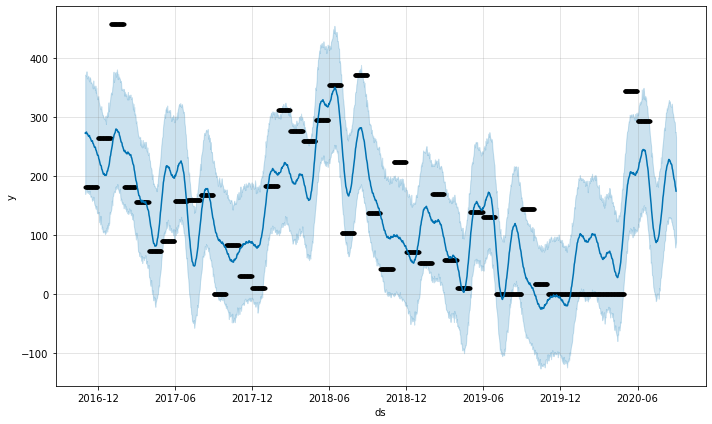

In [81]:
# esto no va en produccion

# plot forecast
model.plot(forecast_df)
pyplot.show()

In [82]:
# nos quedamos con las columnas 'ds' y 'yhat'
forecast_df = forecast_df[['ds', 'yhat']]
forecast_df

ds        yhat
0    2016-11-01  273.279857
1    2016-11-02  272.589545
2    2016-11-03  274.463645
3    2016-11-04  275.085406
4    2016-11-05  272.061844
...         ...         ...
1395 2020-08-27  193.905537
1396 2020-08-28  190.499738
1397 2020-08-29  183.537251
1398 2020-08-30  179.930245
1399 2020-08-31  174.913117

[1400 rows x 2 columns]

In [84]:
# nos quedamos con las filas del ultimo mes que es para el que hemos hecho la predicción
# calculamos el ultimo año
last_year = forecast_df['ds'].dt.year.max()
last_year

2020

In [85]:
# calculamos el ultimo mes del ultimo año creándonos un dataframe donde al final tendremos la estimación del ultimo mes
prediction_df = forecast_df.copy()
prediction_df

ds        yhat
0    2016-11-01  273.279857
1    2016-11-02  272.589545
2    2016-11-03  274.463645
3    2016-11-04  275.085406
4    2016-11-05  272.061844
...         ...         ...
1395 2020-08-27  193.905537
1396 2020-08-28  190.499738
1397 2020-08-29  183.537251
1398 2020-08-30  179.930245
1399 2020-08-31  174.913117

[1400 rows x 2 columns]

In [86]:
# rehacemos el indice con la FECHA columna 'ds'
prediction_df.set_index('ds', drop=False, inplace=True)
prediction_df

ds        yhat
ds                               
2016-11-01 2016-11-01  273.279857
2016-11-02 2016-11-02  272.589545
2016-11-03 2016-11-03  274.463645
2016-11-04 2016-11-04  275.085406
2016-11-05 2016-11-05  272.061844
...               ...         ...
2020-08-27 2020-08-27  193.905537
2020-08-28 2020-08-28  190.499738
2020-08-29 2020-08-29  183.537251
2020-08-30 2020-08-30  179.930245
2020-08-31 2020-08-31  174.913117

[1400 rows x 2 columns]

In [87]:
# calculamos el ultimo mes del ultimo año
last_month = prediction_df[str(last_year)]['ds'].dt.month.max()
last_month

<ipython-input-87-a34f31bb08de>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  last_month = prediction_df[str(last_year)]['ds'].dt.month.max()


8

In [88]:
# hago una variable str con el ultimo año y el ultimo mes
last_year_month = str(last_year) + '-' + str(last_month)
last_year_month

'2020-8'

In [89]:
# calculo la fecha minima a partir de la cual me quedo con los datos
minimum_date_obj = prediction_df[last_year_month]['ds'].min()
minimum_date_obj

<ipython-input-89-63931a1604df>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  minimum_date_obj = prediction_df[last_year_month]['ds'].min()


Timestamp('2020-08-01 00:00:00')

In [90]:
# hago una mascara para quedarme con las filas del ultimo año y del ultimo mes
after_minimum_date_ser = prediction_df['ds'] >= minimum_date_obj
after_minimum_date_ser

ds
2016-11-01    False
2016-11-02    False
2016-11-03    False
2016-11-04    False
2016-11-05    False
              ...  
2020-08-27     True
2020-08-28     True
2020-08-29     True
2020-08-30     True
2020-08-31     True
Name: ds, Length: 1400, dtype: bool

In [91]:
# aplico la mascara para quedarme finalmente con las filas de las transacciones del ultimo mes y del ultimo año
prediction_df = prediction_df.loc[after_minimum_date_ser]
prediction_df

ds        yhat
ds                               
2020-08-01 2020-08-01  168.912967
2020-08-02 2020-08-02  176.791275
2020-08-03 2020-08-03  182.934473
2020-08-04 2020-08-04  188.485370
2020-08-05 2020-08-05  194.236665
...               ...         ...
2020-08-27 2020-08-27  193.905537
2020-08-28 2020-08-28  190.499738
2020-08-29 2020-08-29  183.537251
2020-08-30 2020-08-30  179.930245
2020-08-31 2020-08-31  174.913117

[31 rows x 2 columns]

In [92]:
# hacemos un drop de la columna con las fechas
prediction_df.drop(columns='ds', inplace=True)
prediction_df

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


yhat
ds                    
2020-08-01  168.912967
2020-08-02  176.791275
2020-08-03  182.934473
2020-08-04  188.485370
2020-08-05  194.236665
...                ...
2020-08-27  193.905537
2020-08-28  190.499738
2020-08-29  183.537251
2020-08-30  179.930245
2020-08-31  174.913117

[31 rows x 1 columns]

In [93]:
# damos la predicción final como la media de valores predichos para el mes
final_prediction = float(prediction_df.mean())
final_prediction

205.7720258153242

In [94]:
# a continuación comprobamos que la media de transacciones en supermercado desde el dia 1 del mes anterior es mayor 
# que 0 para poder dar la predicción como valida 

In [95]:
# esto no va en produccion

transacciones_mfilled_df

IMPORTE
2016-10-01    186.3
2016-10-02    186.3
2016-10-03    186.3
2016-10-04    186.3
2016-10-05    186.3
...             ...
2020-07-27    247.5
2020-07-28    247.5
2020-07-29    247.5
2020-07-30    247.5
2020-07-31    247.5

[1400 rows x 1 columns]

In [96]:
# esto no va en produccion

last_date_obj

Timestamp('2020-07-26 00:00:00')

In [99]:
# calculamos la fecha del primer dia del mes anterior a la petición
target_date_obj = last_date_obj - DateOffset(months=1) - MonthBegin(1)
target_date_obj

Timestamp('2020-06-01 00:00:00')

In [100]:
# hago una mascara para solo quedarme con las filas del dataframe a partir de target_date_obj
after_target_date_ser = transacciones_mfilled_df.index >= target_date_obj
after_target_date_ser

array([False, False, False, ...,  True,  True,  True])

In [101]:
# aplico la mascara
final_mean_df = transacciones_mfilled_df.loc[after_target_date_ser]
final_mean_df

IMPORTE
2020-06-01   293.41
2020-06-02   293.41
2020-06-03   293.41
2020-06-04   293.41
2020-06-05   293.41
...             ...
2020-07-27   247.50
2020-07-28   247.50
2020-07-29   247.50
2020-07-30   247.50
2020-07-31   247.50

[61 rows x 1 columns]

In [103]:
# calculo la media final desde el dia 1 del mes anterior a la petición
final_mean = float(final_mean_df.mean())
final_mean

270.0786885245901

In [105]:
# hago el chequeo final de que la predicción sea valida
valid_prediction = False

if final_mean != 0:
    valid_prediction = True
elif float(final_prediction) == 0:
    valid_prediction = True

valid_prediction

True

In [106]:
# hago un dataframe para calcular el año y mes de la predicción
final_date_month_df = prediction_df.copy()
final_date_month_df

yhat
ds                    
2020-08-01  168.912967
2020-08-02  176.791275
2020-08-03  182.934473
2020-08-04  188.485370
2020-08-05  194.236665
...                ...
2020-08-27  193.905537
2020-08-28  190.499738
2020-08-29  183.537251
2020-08-30  179.930245
2020-08-31  174.913117

[31 rows x 1 columns]

In [107]:
# hacemos una columna con el indice
final_date_month_df.reset_index(inplace=True)
final_date_month_df

ds        yhat
0  2020-08-01  168.912967
1  2020-08-02  176.791275
2  2020-08-03  182.934473
3  2020-08-04  188.485370
4  2020-08-05  194.236665
..        ...         ...
26 2020-08-27  193.905537
27 2020-08-28  190.499738
28 2020-08-29  183.537251
29 2020-08-30  179.930245
30 2020-08-31  174.913117

[31 rows x 2 columns]

In [108]:
# calculo el año de la predicción
final_year = final_date_month_df['ds'].dt.year.max()
final_year

2020

In [109]:
# calculo el mes de la predicción
final_month = final_date_month_df['ds'].dt.month.max()
final_month

8

In [111]:
# paso de numero a nombre el mes de la predicción
datetime_object = datetime.strptime(str(final_month), "%m")
final_month_str = datetime_object.strftime("%B")
final_month_str

'August'

In [112]:
# damos resultados finales
print('Tus gasto aproximado en supermercados en ' + final_month_str + '-' + str(final_year) +
      ' sera: ' + str(5 * round(final_prediction / 5)) + ' eur')
print('Predicción válida: ' + str(valid_prediction))

Tus gasto aproximado en supermercados en August-2020 sera: 205 eur
Prediccion válida: True


In [113]:
!python -V

Python 3.8.10


In [114]:
!pip3 list

Package                            Version


---------------------------------- -------------------
absl-py                            0.12.0
aiohttp                            3.7.4
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 2.0.3
anaconda-project                   0.10.0
anyio                              2.2.0
AnyQt                              0.0.13
argh                               0.26.2
argon2-cffi                        20.1.0
arviz                              0.11.2
asn1crypto                         1.4.0
astor                              0.8.1
astroid                            2.5
astropy                            4.2.1
astunparse                         1.6.3
async-generator                    1.10
async-timeout                      3.0.1
atomicwrites                       1.4.0
attrs                              21.2.0
autopep8                           1.5.6
Babel                              2.9.1
backcall                           0.

In [115]:
!pip3 freeze

absl-py @ file:///C:/ci/absl-py_1615411229697/work
aiohttp @ file:///C:/ci/aiohttp_1614361024229/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client==1.7.2
anaconda-navigator==2.0.3
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1621348054992/work
anyio @ file:///C:/ci/anyio_1620153418380/work/dist
AnyQt @ file:///home/conda/feedstock_root/build_artifacts/anyqt_1620306236038/work
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1613037959010/work
arviz @ file:///tmp/build/80754af9/arviz_1614019183254/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astor==0.8.1
astroid @ file:///C:/ci/astroid_1613501047216/work
astropy @ file:///C:/ci/astropy_1617745647203/work
astunparse==1.6.3
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
async-timeout==3.0.1
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1620827162558/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1


termcolor==1.1.0
terminado==0.9.4
testpath @ file:///home/ktietz/src/ci/testpath_1611930608132/work
Theano==1.0.4
threadpoolctl @ file:///tmp/tmp9twdgx9k/threadpoolctl-2.1.0-py3-none-any.whl
tifffile @ file:///tmp/build/80754af9/tifffile_1619636090847/work
toml @ file:///tmp/build/80754af9/toml_1616166611790/work
toolz @ file:///home/linux1/recipes/ci/toolz_1610987900194/work
tornado @ file:///C:/ci/tornado_1606942392901/work
tqdm @ file:///tmp/build/80754af9/tqdm_1615925068909/work
traitlets @ file:///home/ktietz/src/ci/traitlets_1611929699868/work
typing-extensions @ file:///tmp/build/80754af9/typing_extensions_1611751222202/work
ujson @ file:///C:/ci/ujson_1611241570789/work
unicodecsv==0.14.1
urllib3 @ file:///tmp/build/80754af9/urllib3_1615837158687/work
vispy @ file:///D:/bld/vispy_1619790282256/work
watchdog @ file:///C:/ci/watchdog_1620778415875/work
wcwidth @ file:///tmp/build/80754af9/wcwidth_1593447189090/work
webencodings==0.5.1
Werkzeug @ file:///home/ktietz/src/ci/werkze

In [117]:
!pip3 list > requirements_20210721_70_supermercados_ide.txt